Cleaned Generated Samples Shape: (1, 2)
Sample values: [[0. 0.]]
Trained QGAN Discriminator and Generator.


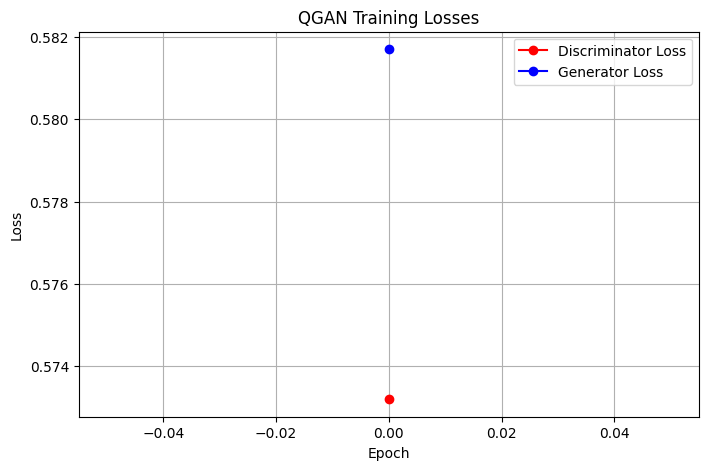

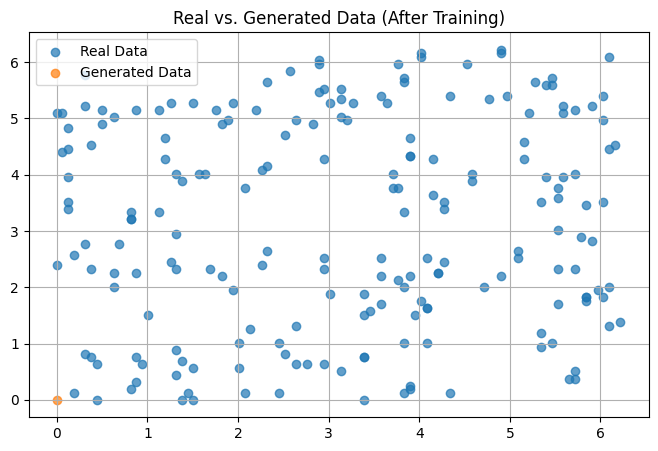

In [1]:
#-------------------------------------------------------------------------
# Training QGAN 
# Chapter 9 in the QUANTUM COMPUTING AND QUANTUM MACHINE LEARNING BOOK
#-------------------------------------------------------------------------
# Version 1.0
# (c) 2025 Jesse Van Griensven, Roydon Fraser, and Jose Rosas 
# License:  MIT - Citation of this work required
#-------------------------------------------------------------------------
# Qiskit changes frequently. 
# We recommend using the latest version from the book code repository at:
# https://github.com/pedroer/quantum-computing-for-engineers/blob/main/requirements.txt

import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms import QGAN
from qiskit_machine_learning.datasets import ad_hoc_data
import warnings
warnings.filterwarnings('ignore')
#-------------------------------------------------------------------------

# Generate training data using ad_hoc_data (compatible with Qiskit ML 0.3.1)
training_features, training_labels, _, _ = ad_hoc_data(
    training_size=100, test_size=0, n=2, gap=0.3, plot_data=False, one_hot=False
)

# Convert dataset into required format
data = np.array(training_features)

# Define bounds for QGAN
bounds = np.array([
    [np.min(data[:, 0]), np.max(data[:, 0])],
    [np.min(data[:, 1]), np.max(data[:, 1])]
])

# Initialize QGAN (without 'epochs' argument)
qgan = QGAN(data, bounds=bounds, num_qubits=[2, 2], batch_size=10)

# Set epochs separately (fixing the previous error)
qgan.epochs = 50  

# Define a Quantum Instance
qi = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=1024)

# Train QGAN using the Quantum Instance (fixing the backend error)
# generated_samples, _ = qgan.run(quantum_instance=qi)
result = qgan.run(quantum_instance=qi)

# Get output from generator
raw_output = qgan.generator.get_output(qi)

# Normalize structure into a proper 2D array of [x, y] pairs
# Filter out anything that's not a 1D or 2D list/array with 2 elements
processed_samples = []
for entry in raw_output:
    if isinstance(entry, (list, np.ndarray)) and len(entry) == 2:
        processed_samples.append(np.array(entry))
    elif isinstance(entry, (list, np.ndarray)) and isinstance(entry[0], (list, np.ndarray)) and len(entry[0]) == 2:
        processed_samples.append(np.array(entry[0]))
    # else: skip invalid or scalar entries

generated_samples = np.array(processed_samples)

print("Cleaned Generated Samples Shape:", generated_samples.shape)
print("Sample values:", generated_samples[:5])

print("Trained QGAN Discriminator and Generator.")

# Extract loss values for visualization
loss_d = np.atleast_1d(result.get('loss_d', []))
loss_g = np.atleast_1d(result.get('loss_g', []))
epochs_range = range(len(loss_d))

# Plot training losses
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, loss_d, 'r-o', label='Discriminator Loss')
plt.plot(epochs_range, loss_g, 'b-o', label='Generator Loss')
plt.title("QGAN Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# Compare Real vs. Generated Data
plt.figure(figsize=(8, 5))
plt.title("Real vs. Generated Data (After Training)")

# Real data scatter plot
plt.scatter(data[:, 0], data[:, 1], alpha=0.7, label="Real Data")

# Generated data scatter plot
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.7, label="Generated Data")

plt.legend()
plt.grid(True)
plt.show()
